In [1]:
!git clone https://github.com/pondelion/Algotham.git

Cloning into 'Algotham'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 227 (delta 88), reused 193 (delta 61), pack-reused 0
Receiving objects: 100% (227/227), 32.60 KiB | 4.66 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [1]:
%cd Algotham

/content/Algotham


In [3]:
ls

algotham/  examples/  Pipfile  Pipfile.lock  README.md  requirements.txt


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 133kB 3.2MB/s 
     |████████████████████████████████| 6.5MB 13.8MB/s 
     |████████████████████████████████| 14.5MB 284kB/s 
     |████████████████████████████████| 10.5MB 156kB/s 
     |████████████████████████████████| 512kB 37.7MB/s 
     |████████████████████████████████| 276kB 13.2MB/s 
     |████████████████████████████████| 133kB 44.8MB/s 
  Created wheel for jpbizday: filename=jpbizday-0.0.3-cp36-none-any.whl size=4327 sha256=a81b61fac966f0af845735cd0c6837fa5904b6202382a875ff26711fe5882f1f
  Stored in directory: /root/.cache/pip/wheels/22/0b/ae/e12bc194a7a22998e2a13ea88526a6df0f5e9e394d7904b72b
  Created wheel for overrides: filename=overrides-3.1.0-cp36-none-any.whl size=10174 sha256=75d382520e6ec217723c3679de3daa18fdd467ae37afd9de3462cb9679f44f3f
  Stored in directory: /root/.cache/pip/wheels/5c/24/13/6ef8600e6f147c95e595f1289a86a3cc82ed65df57582c65a9
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=4

In [2]:
!echo 'ACCESS_KEY_ID: *****' >> algotham/config/aws.yml
!echo 'SECRET_ACCESS_KEY: *****' >> algotham/config/aws.yml
!echo 'REGION_NAME: ap-northeast-1' >> algotham/config/aws.yml
!echo 'S3_BUCKET_NAME: fin-app' >> algotham/config/aws.yml

In [6]:
!echo 'STOCKLIST_FILE: s3://fin-app/stocklist/stocklist.csv' >> algotham/config/data_location.yml
!echo 'STOCKPRICE_BASEDIR: s3://fin-app/stockprice' >> algotham/config/data_location.yml
!echo 'STOCKPRICE_CONCAT_BASEDIR: s3://fin-app/stockprice_concat' >> algotham/config/data_location.yml
!echo 'STOCKPRICE_CANDLECHART_BASEDIR: s3://fin-app/stockprice_candlechart' >> algotham/config/data_location.yml
!echo 'ECONOMIC_INDICATOR_BASEDIR: s3://fin-app/economic_indicator' >> algotham/config/data_location.yml
!echo 'LOCAL_CACHE_DIR: /var/tmp' >> algotham/config/data_location.yml

In [7]:
!echo 'LOGDIR: /content/Algotham/log' >> algotham/config/dev.yml

In [8]:
import sys
import random
from datetime import datetime, timedelta
from typing import List

from overrides import overrides
import jpbizday

from algotham.rule import (
    BaseStockSelectionRule,
    BaseTimingRule,
    BaseVolumeRule
)
from algotham.data.stock import Stock
from algotham.algo import SimulatedAlgo
from algotham.simulator.backtest import BackTest
from algotham.portfolio import Portfolio

In [9]:
start_dt = datetime(2019, 4, 1)
end_dt = datetime(2019, 7, 1)

In [10]:
class RandomStockSelectionRule(BaseStockSelectionRule):

    STOCK_CANDIDATES = [3853, 3987, 6029, 4120, 3747]

    @overrides
    def select_stocks(self, dt: datetime) -> List[Stock]:

        selected_codes = random.sample(
            RandomStockSelectionRule.STOCK_CANDIDATES,
            3
        )
        stocks = [Stock(code=code) for code in selected_codes]
        return stocks

In [11]:
class MarketOpeningTimingRule(BaseTimingRule):

    def __init__(self):
        self._next_opening = start_dt
        self._next_opening = self._next_opening.replace(
            hour=9,
            minute=0,
            second=0
        )

    @overrides
    def wait_for_next(self):
        self._next_opening += timedelta(days=1)
        while not jpbizday.is_bizday(self._next_opening):
            self._next_opening += timedelta(days=1)
        print(f'waiting until {self._next_opening }')
        self.wait_until(self._next_opening)

In [12]:
class RandomVolumeRule(BaseVolumeRule):

    @overrides
    def decide_volume(self, stock: Stock, dt: datetime) -> int:
        return random.randint(-5, 5)

In [13]:
random_trade_system = SimulatedAlgo(
    timing_rule=MarketOpeningTimingRule(),
    stock_selection_rule=RandomStockSelectionRule(),
    volume_rule=RandomVolumeRule(),
    init_portfolio=Portfolio(cash=100000)
)

In [14]:
back_test = BackTest(
    random_trade_system,
    start_dt=start_dt,
    end_dt=end_dt,
)

In [15]:
back_test.run()

waiting until 2019-04-02 09:00:00


INFO : 2020-08-02 05:50:27,074 : [CSVHistoricalData] Downloading s3://fin-app/stockprice_concat/3853.csv to /var/tmp/stock/3853.csv
INFO : 2020-08-02 05:50:28,328 : [CSVHistoricalData] Downloading s3://fin-app/stockprice_concat/6029.csv to /var/tmp/stock/6029.csv


buy/sell : code=3853 : volume=1 : cash=-927 : 


INFO : 2020-08-02 05:50:28,673 : [CSVHistoricalData] Downloading s3://fin-app/stockprice_concat/3747.csv to /var/tmp/stock/3747.csv


buy/sell : code=6029 : volume=3 : cash=-1137 : 
buy/sell : code=3747 : volume=2 : cash=-596 : 
waiting until 2019-04-03 09:00:00


INFO : 2020-08-02 05:50:29,500 : [BaseTransaction] Skipped transaction, stock=6029, volume=-4 : stock is insufficient to sell
INFO : 2020-08-02 05:50:29,502 : [BaseTransaction] Skipped transaction, stock=3853, volume=-5 : stock is insufficient to sell


buy/sell : code=3747 : volume=-1 : cash=297 : 
waiting until 2019-04-04 09:00:00


INFO : 2020-08-02 05:50:29,790 : [CSVHistoricalData] Downloading s3://fin-app/stockprice_concat/3987.csv to /var/tmp/stock/3987.csv
INFO : 2020-08-02 05:50:30,125 : [CSVHistoricalData] Downloading s3://fin-app/stockprice_concat/4120.csv to /var/tmp/stock/4120.csv


buy/sell : code=3987 : volume=3 : cash=-4965 : 
buy/sell : code=3747 : volume=1 : cash=-297 : 


INFO : 2020-08-02 05:50:30,619 : [BaseTransaction] Skipped transaction, stock=4120, volume=-4 : stock is insufficient to sell


waiting until 2019-04-05 09:00:00


INFO : 2020-08-02 05:50:30,914 : [BaseTransaction] Skipped transaction, stock=3987, volume=-4 : stock is insufficient to sell


buy/sell : code=4120 : volume=2 : cash=-2800 : 
buy/sell : code=3853 : volume=4 : cash=-3592 : 
waiting until 2019-04-08 09:00:00
buy/sell : code=6029 : volume=3 : cash=-1149 : 
buy/sell : code=4120 : volume=3 : cash=-4248 : 
buy/sell : code=3987 : volume=-3 : cash=4881 : 
waiting until 2019-04-09 09:00:00


INFO : 2020-08-02 05:50:32,046 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0


buy/sell : code=3747 : volume=5 : cash=-1490 : 
buy/sell : code=3853 : volume=4 : cash=-3552 : 
waiting until 2019-04-10 09:00:00


INFO : 2020-08-02 05:50:32,332 : [BaseTransaction] Skipped transaction, stock=3987, volume=-4 : stock is insufficient to sell


buy/sell : code=4120 : volume=2 : cash=-2754 : 
buy/sell : code=3853 : volume=-4 : cash=3544 : 
waiting until 2019-04-11 09:00:00


INFO : 2020-08-02 05:50:32,665 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0


buy/sell : code=3987 : volume=5 : cash=-7670 : 
buy/sell : code=3747 : volume=5 : cash=-1475 : 
waiting until 2019-04-12 09:00:00
buy/sell : code=4120 : volume=-5 : cash=6780 : 
buy/sell : code=3853 : volume=1 : cash=-847 : 
buy/sell : code=3747 : volume=3 : cash=-879 : 
waiting until 2019-04-15 09:00:00
buy/sell : code=4120 : volume=5 : cash=-6735 : 
buy/sell : code=6029 : volume=-1 : cash=375 : 
buy/sell : code=3747 : volume=3 : cash=-876 : 
waiting until 2019-04-16 09:00:00


INFO : 2020-08-02 05:50:34,076 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0


buy/sell : code=3747 : volume=-2 : cash=572 : 
buy/sell : code=3853 : volume=2 : cash=-1698 : 
waiting until 2019-04-17 09:00:00
buy/sell : code=6029 : volume=2 : cash=-762 : 
buy/sell : code=4120 : volume=2 : cash=-2750 : 
buy/sell : code=3853 : volume=-1 : cash=842 : 
waiting until 2019-04-18 09:00:00
buy/sell : code=3853 : volume=-1 : cash=838 : 
buy/sell : code=3747 : volume=-4 : cash=1132 : 
buy/sell : code=6029 : volume=-4 : cash=1508 : 
waiting until 2019-04-19 09:00:00


INFO : 2020-08-02 05:50:34,938 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0


buy/sell : code=4120 : volume=-1 : cash=1377 : 
buy/sell : code=3853 : volume=5 : cash=-4165 : 
waiting until 2019-04-22 09:00:00


INFO : 2020-08-02 05:50:35,799 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0


buy/sell : code=3747 : volume=2 : cash=-556 : 
buy/sell : code=3853 : volume=5 : cash=-4155 : 
waiting until 2019-04-23 09:00:00


INFO : 2020-08-02 05:50:36,097 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : code=4120 : volume=2 : cash=-2806 : 
buy/sell : code=3853 : volume=-2 : cash=1650 : 
waiting until 2019-04-24 09:00:00
buy/sell : code=3853 : volume=3 : cash=-2454 : 
buy/sell : code=3747 : volume=-1 : cash=276 : 
buy/sell : code=4120 : volume=4 : cash=-5604 : 
waiting until 2019-04-25 09:00:00


INFO : 2020-08-02 05:50:36,683 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : code=3987 : volume=5 : cash=-8165 : 
buy/sell : code=6029 : volume=5 : cash=-1890 : 
waiting until 2019-04-26 09:00:00
buy/sell : code=6029 : volume=4 : cash=-1484 : 
buy/sell : code=4120 : volume=-2 : cash=2818 : 
buy/sell : code=3853 : volume=-2 : cash=1580 : 
waiting until 2019-04-30 09:00:00


INFO : 2020-08-02 05:50:38,135 : [BaseTransaction] Skipped transaction, stock=4120, volume=5 : stock price data is missing
INFO : 2020-08-02 05:50:38,137 : [BaseTransaction] Skipped transaction, stock=3853, volume=-3 : stock price data is missing
INFO : 2020-08-02 05:50:38,150 : [BaseTransaction] Skipped transaction, stock=3747, volume=5 : stock price data is missing


stock data not found : 2019-04-30 00:00:00
stock data not found : 2019-04-30 00:00:00
stock data not found : 2019-04-30 00:00:00
waiting until 2019-05-01 09:00:00


INFO : 2020-08-02 05:50:38,438 : [BaseTransaction] Skipped transaction, stock=6029, volume=-1 : stock price data is missing
INFO : 2020-08-02 05:50:38,440 : [BaseTransaction] Skipped transaction, stock=3987, volume=-4 : stock price data is missing
INFO : 2020-08-02 05:50:38,448 : [BaseTransaction] Skipped transaction, stock=3853, volume=-3 : stock price data is missing


stock data not found : 2019-05-01 00:00:00
stock data not found : 2019-05-01 00:00:00
stock data not found : 2019-05-01 00:00:00
waiting until 2019-05-02 09:00:00


INFO : 2020-08-02 05:50:38,734 : [BaseTransaction] Skipped transaction, stock=3853, volume=5 : stock price data is missing
INFO : 2020-08-02 05:50:38,740 : [BaseTransaction] Skipped transaction, stock=3987, volume=1 : stock price data is missing
INFO : 2020-08-02 05:50:38,742 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0


stock data not found : 2019-05-02 00:00:00
stock data not found : 2019-05-02 00:00:00
waiting until 2019-05-07 09:00:00
buy/sell : code=6029 : volume=-2 : cash=764 : 
buy/sell : code=3853 : volume=3 : cash=-2418 : 
buy/sell : code=3987 : volume=-4 : cash=6728 : 
waiting until 2019-05-08 09:00:00
buy/sell : code=3853 : volume=-1 : cash=807 : 
buy/sell : code=6029 : volume=-3 : cash=1167 : 
buy/sell : code=3987 : volume=3 : cash=-5262 : 
waiting until 2019-05-09 09:00:00
buy/sell : code=3747 : volume=-2 : cash=532 : 
buy/sell : code=3853 : volume=3 : cash=-2382 : 
buy/sell : code=3987 : volume=-1 : cash=1793 : 
waiting until 2019-05-10 09:00:00
buy/sell : code=4120 : volume=1 : cash=-1336 : 
buy/sell : code=3747 : volume=-2 : cash=524 : 
buy/sell : code=3987 : volume=-5 : cash=8785 : 
waiting until 2019-05-13 09:00:00
buy/sell : code=3747 : volume=-3 : cash=768 : 
buy/sell : code=6029 : volume=2 : cash=-610 : 
buy/sell : code=4120 : volume=-2 : cash=2674 : 
waiting until 2019-05-14 09:00

INFO : 2020-08-02 05:50:42,205 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0


buy/sell : code=4120 : volume=-5 : cash=6575 : 
buy/sell : code=6029 : volume=-4 : cash=1092 : 
waiting until 2019-05-15 09:00:00
buy/sell : code=4120 : volume=-5 : cash=6670 : 
buy/sell : code=3853 : volume=-2 : cash=1982 : 
buy/sell : code=3747 : volume=-3 : cash=747 : 
waiting until 2019-05-16 09:00:00


INFO : 2020-08-02 05:50:42,853 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0


buy/sell : code=4120 : volume=2 : cash=-2622 : 
buy/sell : code=3853 : volume=4 : cash=-4024 : 
waiting until 2019-05-17 09:00:00


INFO : 2020-08-02 05:50:43,148 : [BaseTransaction] Skipped transaction, stock=4120, volume=-5 : stock is insufficient to sell


buy/sell : code=3747 : volume=-3 : cash=696 : 
buy/sell : code=6029 : volume=5 : cash=-1415 : 
waiting until 2019-05-20 09:00:00
buy/sell : code=3747 : volume=1 : cash=-249 : 
buy/sell : code=4120 : volume=4 : cash=-5184 : 
buy/sell : code=6029 : volume=-2 : cash=578 : 
waiting until 2019-05-21 09:00:00
buy/sell : code=6029 : volume=-4 : cash=1168 : 
buy/sell : code=4120 : volume=-4 : cash=5224 : 
buy/sell : code=3853 : volume=5 : cash=-5145 : 
waiting until 2019-05-22 09:00:00


INFO : 2020-08-02 05:50:44,559 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0


buy/sell : code=3747 : volume=1 : cash=-236 : 
buy/sell : code=6029 : volume=4 : cash=-1164 : 
waiting until 2019-05-23 09:00:00
buy/sell : code=3747 : volume=-1 : cash=233 : 
buy/sell : code=3987 : volume=-3 : cash=4506 : 
buy/sell : code=4120 : volume=4 : cash=-5256 : 
waiting until 2019-05-24 09:00:00
buy/sell : code=4120 : volume=5 : cash=-6475 : 
buy/sell : code=3747 : volume=4 : cash=-908 : 
buy/sell : code=3853 : volume=2 : cash=-2060 : 
waiting until 2019-05-27 09:00:00


INFO : 2020-08-02 05:50:45,992 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0


buy/sell : code=3747 : volume=-2 : cash=460 : 
buy/sell : code=3987 : volume=3 : cash=-4614 : 
waiting until 2019-05-28 09:00:00
buy/sell : code=3987 : volume=-1 : cash=1557 : 
buy/sell : code=6029 : volume=-3 : cash=864 : 
buy/sell : code=3853 : volume=2 : cash=-2202 : 
waiting until 2019-05-29 09:00:00
buy/sell : code=6029 : volume=-3 : cash=861 : 
buy/sell : code=3747 : volume=1 : cash=-237 : 
buy/sell : code=3987 : volume=1 : cash=-1515 : 
waiting until 2019-05-30 09:00:00
buy/sell : code=3987 : volume=5 : cash=-7330 : 
buy/sell : code=4120 : volume=-5 : cash=6395 : 
buy/sell : code=3853 : volume=2 : cash=-2220 : 
waiting until 2019-05-31 09:00:00
buy/sell : code=6029 : volume=-2 : cash=570 : 
buy/sell : code=3747 : volume=5 : cash=-1180 : 
buy/sell : code=3853 : volume=-4 : cash=4416 : 
waiting until 2019-06-03 09:00:00


INFO : 2020-08-02 05:50:48,002 : [BaseTransaction] Skipped transaction, stock=6029, volume=-2 : stock is insufficient to sell


buy/sell : code=3987 : volume=-3 : cash=4182 : 
buy/sell : code=3853 : volume=-5 : cash=5190 : 
waiting until 2019-06-04 09:00:00
buy/sell : code=3853 : volume=1 : cash=-1001 : 
buy/sell : code=4120 : volume=-5 : cash=6095 : 
buy/sell : code=3747 : volume=4 : cash=-868 : 
waiting until 2019-06-05 09:00:00


INFO : 2020-08-02 05:50:48,595 : [BaseTransaction] Skipped transaction, stock=4120, volume=-4 : stock is insufficient to sell


buy/sell : code=3853 : volume=-4 : cash=4036 : 
buy/sell : code=3987 : volume=-1 : cash=1414 : 
waiting until 2019-06-06 09:00:00
buy/sell : code=3747 : volume=1 : cash=-221 : 
buy/sell : code=6029 : volume=3 : cash=-843 : 
buy/sell : code=3853 : volume=5 : cash=-4965 : 
waiting until 2019-06-07 09:00:00


INFO : 2020-08-02 05:50:49,171 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0


buy/sell : code=3853 : volume=-2 : cash=1996 : 
buy/sell : code=3987 : volume=-1 : cash=1401 : 
waiting until 2019-06-10 09:00:00


INFO : 2020-08-02 05:50:50,012 : [BaseTransaction] Skipped transaction, stock=3987, volume=-4 : stock is insufficient to sell
INFO : 2020-08-02 05:50:50,015 : [BaseTransaction] Skipped transaction, stock=6029, volume=-5 : stock is insufficient to sell


buy/sell : code=3747 : volume=-5 : cash=1145 : 
waiting until 2019-06-11 09:00:00
buy/sell : code=3987 : volume=-3 : cash=4332 : 
buy/sell : code=6029 : volume=3 : cash=-858 : 
buy/sell : code=3747 : volume=2 : cash=-460 : 
waiting until 2019-06-12 09:00:00
buy/sell : code=4120 : volume=4 : cash=-4868 : 
buy/sell : code=3987 : volume=5 : cash=-7275 : 
buy/sell : code=3747 : volume=-2 : cash=458 : 
waiting until 2019-06-13 09:00:00


INFO : 2020-08-02 05:50:50,929 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0


buy/sell : code=3853 : volume=-1 : cash=967 : 
buy/sell : code=3747 : volume=2 : cash=-450 : 
waiting until 2019-06-14 09:00:00
buy/sell : code=3747 : volume=3 : cash=-666 : 
buy/sell : code=6029 : volume=3 : cash=-846 : 
buy/sell : code=3987 : volume=-1 : cash=1469 : 
waiting until 2019-06-17 09:00:00


INFO : 2020-08-02 05:50:52,066 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : code=3853 : volume=3 : cash=-3063 : 
buy/sell : code=4120 : volume=-1 : cash=1226 : 
waiting until 2019-06-18 09:00:00
buy/sell : code=3987 : volume=3 : cash=-4557 : 
buy/sell : code=6029 : volume=-1 : cash=282 : 
buy/sell : code=4120 : volume=-4 : cash=4864 : 
waiting until 2019-06-19 09:00:00


INFO : 2020-08-02 05:50:52,656 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 05:50:52,658 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : code=3853 : volume=-1 : cash=1012 : 
waiting until 2019-06-20 09:00:00
buy/sell : code=4120 : volume=3 : cash=-3657 : 
buy/sell : code=3987 : volume=-4 : cash=6000 : 
buy/sell : code=3747 : volume=2 : cash=-442 : 
waiting until 2019-06-21 09:00:00
buy/sell : code=3747 : volume=-4 : cash=876 : 
buy/sell : code=3853 : volume=5 : cash=-5245 : 
buy/sell : code=6029 : volume=5 : cash=-1385 : 
waiting until 2019-06-24 09:00:00
buy/sell : code=6029 : volume=3 : cash=-825 : 
buy/sell : code=3853 : volume=-5 : cash=5285 : 
buy/sell : code=3747 : volume=-2 : cash=434 : 
waiting until 2019-06-25 09:00:00


INFO : 2020-08-02 05:50:54,393 : [BaseTransaction] Skipped transaction, stock=4120, volume=-3 : stock price data is missing


buy/sell : code=6029 : volume=-5 : cash=1385 : 
stock data not found : 2019-06-25 00:00:00
buy/sell : code=3853 : volume=1 : cash=-1050 : 
waiting until 2019-06-26 09:00:00
buy/sell : code=3853 : volume=-1 : cash=1070 : 
buy/sell : code=3747 : volume=-4 : cash=872 : 
buy/sell : code=4120 : volume=-2 : cash=2434 : 
waiting until 2019-06-27 09:00:00


INFO : 2020-08-02 05:50:54,973 : [BaseTransaction] Skipped transaction, stock=4120, volume=-4 : stock is insufficient to sell


buy/sell : code=3853 : volume=1 : cash=-1100 : 
buy/sell : code=3987 : volume=4 : cash=-6264 : 
waiting until 2019-06-28 09:00:00
buy/sell : code=4120 : volume=1 : cash=-1208 : 
buy/sell : code=3853 : volume=1 : cash=-1100 : 
buy/sell : code=3747 : volume=-5 : cash=1105 : 
waiting until 2019-07-01 09:00:00


In [16]:
result = back_test.result()

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
df_transaction_history = result.transaction_history

In [19]:
df_transaction_history

,datetime,stock,volume
0,2019-04-02 09:00:00,3853,1
1,2019-04-02 09:00:00,6029,3
2,2019-04-02 09:00:00,3747,2
3,2019-04-03 09:00:00,3747,-1
4,2019-04-04 09:00:00,3987,3
...,...,...,...
141,2019-06-27 09:00:00,3853,1
142,2019-06-27 09:00:00,3987,4
143,2019-06-28 09:00:00,4120,1
144,2019-06-28 09:00:00,3853,1


In [20]:
portfolio_history = result.portfolio_history
df_portfolio_history = pd.DataFrame({
    'datetime': portfolio_history['datetime'],
    'total_asset': portfolio_history['total_asset']
})
df_portfolio_history['datetime'] = pd.to_datetime(df_portfolio_history['datetime'])

In [21]:
df_portfolio_history

,datetime,total_asset
0,2019-04-02 09:00:00,100000.0
1,2019-04-02 09:00:00,100000.0
2,2019-04-02 09:00:00,100000.0
3,2019-04-03 09:00:00,99999.0
4,2019-04-04 09:00:00,99995.0
...,...,...
141,2019-06-27 09:00:00,102963.0
142,2019-06-27 09:00:00,102963.0
143,2019-06-28 09:00:00,103083.0
144,2019-06-28 09:00:00,103083.0


Text(0, 0.5, 'total asset')

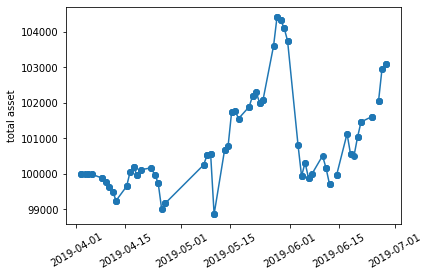

In [27]:
plt.plot(df_portfolio_history['datetime'], df_portfolio_history['total_asset'], marker='o')
plt.xticks(rotation=30)
plt.ylabel('total asset')